In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score

df_fake_news = pd.read_csv("Fake.csv")
df_true_news = pd.read_csv("True.csv")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abdurrazaq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df_fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
df_fake_news["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [5]:
#Create a label called category that determines whether a news is fake or not
df_fake_news["category"]=0
df_true_news["category"]=1

#Combine both dataset
df = pd.concat([df_fake_news, df_true_news]).reset_index(drop=True)
df["category"].value_counts()

0    23481
1    21417
Name: category, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


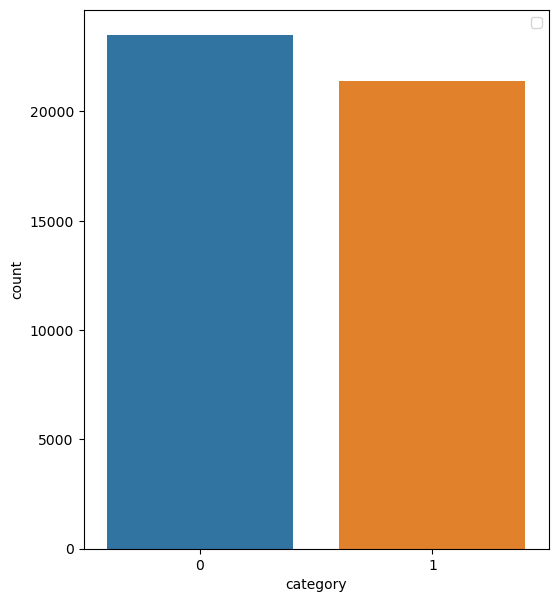

In [6]:
#setting the figure size
plt.figure(figsize=(6,7))
sns.countplot(x="category", data=df)
plt.legend()

ValueError: could not convert string to float: 'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.'

<Figure size 1000x700 with 0 Axes>

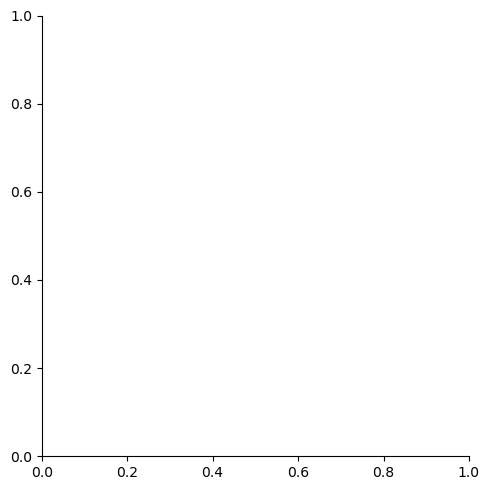

In [7]:
plt.figure(figsize=(10,7))
sns.lmplot(x="text", y="category", data=df, fit_reg=True, ci=None)

In [57]:
df = df[["text","category"]]
df.tail()

,text,category
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,1


<h1>#Clean the data </h1>

In [58]:
#Check for columns with null value
df.isnull().sum()*100/(len(df))

text        0.0
category    0.0
dtype: float64

In [59]:
#number of rows before removing rows with empty string
df.shape

(44898, 2)

In [60]:
#Remove rows whose text columns is empty string ""  
df = df[df['text'].str.strip() != '']
df.shape

(44267, 2)

In [76]:
#combine both spacy and nltk
stopwords_combined = set((set(nlp.Defaults.stop_words)| set(stopwords.words("english"))))
lemma = WordNetLemmatizer()

#text cleaning function
def sanitize_text(text):
    
    string = ""
    
    #lower casing
    text=text.lower()
        
    #simplifying text
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)
    
    #removing any special character
    text=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",text)
    text=re.sub(r"\s+"," ",text)
    text=re.sub('[^A-Za-z0-9]+',' ', text)
    
    for word in text.split():
        if word not in stopwords_combined:
            string+=lemma.lemmatize(word)+" "
    
    return string

clean_text = sanitize_text(df["text"][0][:100])
print(clean_text)
print(df["text"][0][:100])

donald trump wish american happy new year leave instead 
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had


In [ ]:
df["text"] = df["text"].apply(sanitize_text)
df["text"].head()

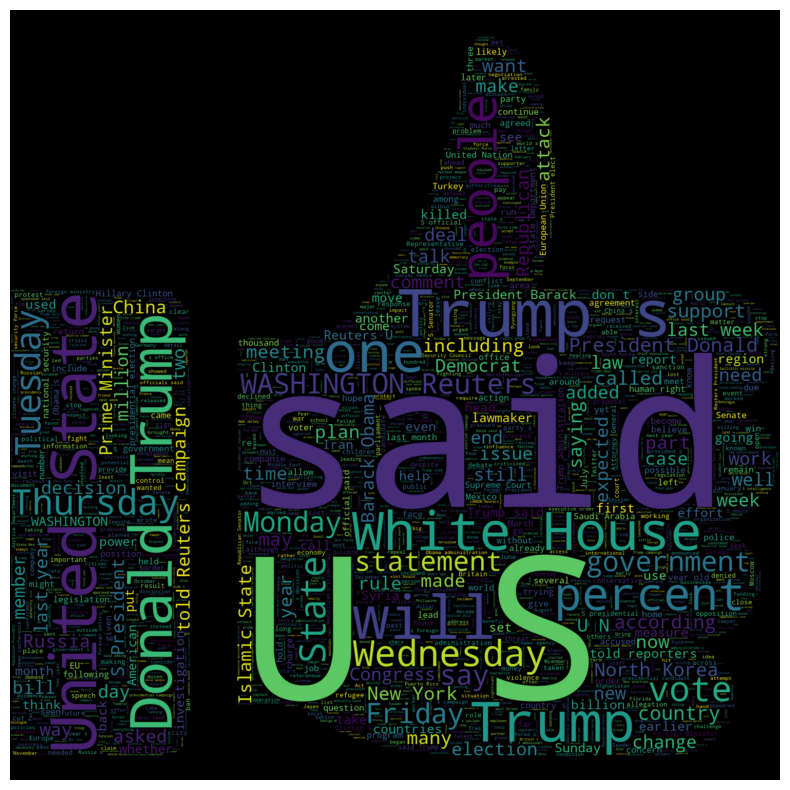

In [62]:
#True News with wordcloud
icon = Image.open("imgs/thumbsup2.png")
mask=Image.new(mode="RGB",size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)
rgb_array=np.array(mask)

wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width=1600, height=800)

# Join and feed text
text_input = " ".join(df[df.category == 1].text)
wc.generate(text_input)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

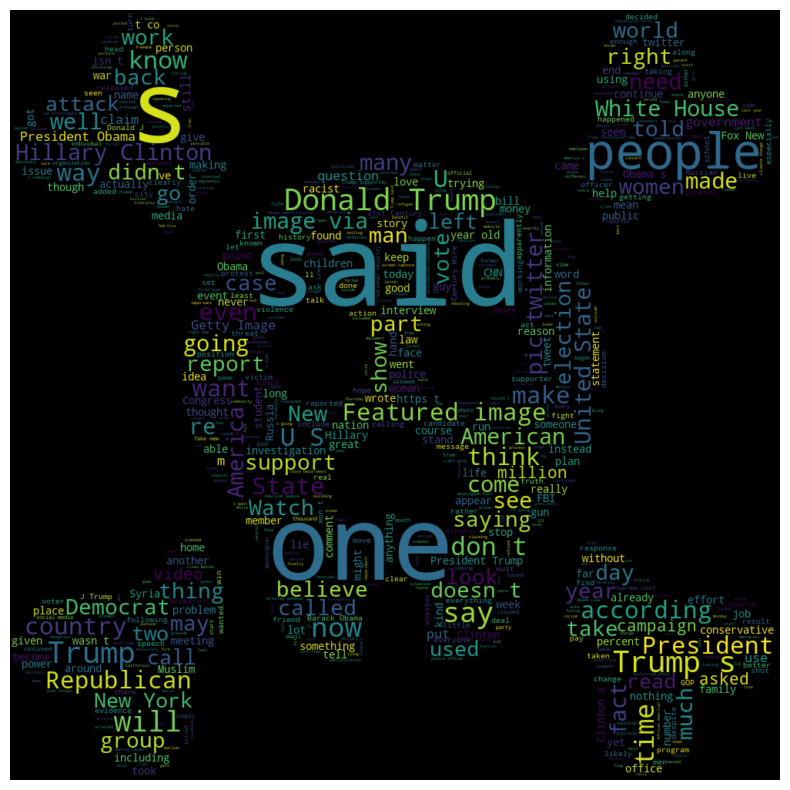

In [63]:
#Fake News

skull_image = "imgs/skull2.png"
icon = Image.open(skull_image)
mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)

rgb_array= np.array(mask)

plt.figure(figsize=(10,10))
wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width = 1600, 
               height = 800)
wc.generate(" ".join(df[df.category == 0].text))
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

In [66]:
def calculate_percentage(part, total):
    if total == 0:
        return 0
    return (part / total) * 100


#split the data
x= df["text"] #feature (predictors)
y= df["category"] #labels (target)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(
    f"Predictors size: {x_train.shape[0]} ({calculate_percentage(x_train.shape[0], x.shape[0]):.2f}%) for train, "
    f"{x_test.shape[0]} ({calculate_percentage(x_test.shape[0], x.shape[0]):.2f}%) for test"
)

print(
    f"Target size: {y_train.shape[0]} ({calculate_percentage(y_train.shape[0], y.shape[0]):.2f}%) for train, "
    f"{y_test.shape[0]} ({calculate_percentage(y_test.shape[0], y.shape[0]):.2f}%) for test"
)


Predictors size: 35413 (80.00%) for train, 8854 (20.00%) for test
Target size: 35413 (80.00%) for train, 8854 (20.00%) for test


In [77]:
#TFIDF Vectorizer

vectorizer =TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)


In [78]:
x_train_tfidf

<35413x111562 sparse matrix of type '<class 'numpy.float64'>'
	with 7523300 stored elements in Compressed Sparse Row format>

<h1> #Model Building using LinearSVC</h1>

In [79]:
classifier = LinearSVC(dual=True)
classifier.fit(x_train_tfidf, y_train)

LinearSVC(dual=True)

In [80]:
text_classifier = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC(dual=True))])
text_classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC(dual=True))])

<h1>#Model Evaluation</h1>

In [81]:
predictions = text_classifier.predict(x_test)

In [82]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4585
           1       0.99      1.00      0.99      4269

    accuracy                           1.00      8854
   macro avg       1.00      1.00      1.00      8854
weighted avg       1.00      1.00      1.00      8854



In [83]:
print(metrics.accuracy_score(y_test, predictions))

0.9950304946916648


In [84]:
print(metrics.confusion_matrix(y_test, predictions))

[[4561   24]
 [  20 4249]]
